In [56]:
from glob import glob
from datasets import Dataset, load_dataset
import numpy as np
import pandas as pd
from pprint import pprint
import os
import random
import json
from tqdm import tqdm
import requests
import json
from transformers import AutoTokenizer, AutoModel, AutoConfig, pipeline
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.output_parsers import JsonOutputParser
import uuid
import html
import re

### Utils

In [39]:
### text completion
MODEL_LIST = [
    "Qwen/Qwen2-72B-Instruct",
    "meta-llama/Meta-Llama-3-70B-Instruct-Turbo",
]
COMPLETION_MODEL = MODEL_LIST[1]
with open("./keys.together.txt", "r") as f:
    TOGETHER_AI_API_KEY = random.choice([x.strip() for x in f.readlines()])

def get_completion(prompt):
    response = requests.post(
        "https://api.together.xyz/v1/chat/completions",
        headers={
            "Authorization": f"Bearer {TOGETHER_AI_API_KEY}",
            "Content-Type": "application/json",
        },
        json={
            "model": COMPLETION_MODEL,
            "messages": [{"role": "user", "content": prompt}],
        },
    )
    return response.json()["choices"][0]["message"]["content"]

In [40]:
### load corpus
def load_jsonl(path):
    with open(path, "r") as f:
        data = [json.loads(l) for l in f.readlines()]
    return data


def get_corpus_from_list_of_text(
    list_of_text,
    tokenizer=AutoTokenizer.from_pretrained("BAAI/bge-m3"),
    chunk_size=900,
    chunk_overlap=300,
):
    corpus = [
        {
            "id": uuid.uuid4().hex,
            "text": text
        }
        for text in list_of_text
    ]
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        length_function=lambda x: len(tokenizer.tokenize(x))
    )
    for d in tqdm(corpus):
        chunks = text_splitter.split_text(d['text'])
        d['chunks'] = chunks
    return corpus

data = load_jsonl("./data/legal_qa.jsonl")
corpus = []
for d in data:
    corpus.extend(d['context'])
list_text = list(set(corpus))

corpus = get_corpus_from_list_of_text(list_text)

100%|██████████| 6629/6629 [00:21<00:00, 309.20it/s]


<AxesSubplot:>

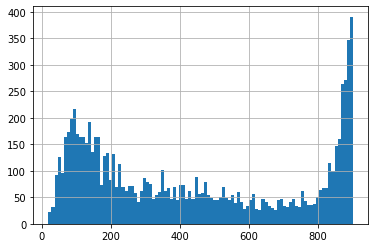

In [55]:
tokenizer = AutoTokenizer.from_pretrained("BAAI/bge-m3")
chunk_lengths = []
for d in corpus:
    chunk_lengths.extend([len(tokenizer.tokenize(c)) for c in d["chunks"]])
pd.Series(chunk_lengths).hist(bins=100)

In [49]:
### parse json
class JsonParser:
    @staticmethod
    def parse_list(text):
        first = text.find("[")
        last = text.rfind("]")
        return json.loads(text[first:last+1])
    @staticmethod
    def parse_dict(text):
        first = text.find("{")
        last = text.rfind("}")
        return json.loads(text[first:last+1])

In [57]:
### clean string
def clean_str(input):
    if not isinstance(input, str):
        return input
    result = html.unescape(input.strip())
    return re.sub(r"[\x00-\x1f\x7f-\x9f]", "", result)

In [41]:
UNTYPED_GRAPH_EXTRACTION_PROMPT = """
-Goal-
Given a text document that is potentially relevant to this activity, first identify all entities needed from the text in order to capture the information and ideas in the text. Next, report all relationships among the identified entities.

-Steps-
1. Identify all entities. For each identified entity, extract the following information:
- entity_name: Name of the entity, capitalized
- entity_type: Suggest several labels or categories for the entity. The categories should not be specific, but should be as general as possible.
- entity_description: Comprehensive description of the entity's attributes and activities
Format each entity output as a JSON entry with the following format:

{"name": <entity name>, "type": <entity_type>, "description": <entity_description>}

2. From the entities identified in step 1, identify all pairs of (source_entity, target_entity) that are *clearly related* to each other.
For each pair of related entities, extract the following information:
- source_entity: name of the source entity, as identified in step 1
- target_entity: name of the target entity, as identified in step 1
- relationship_description: explanation as to why you think the source entity and the target entity are related to each other
- relationship_strength: an integer score between 1 to 10, indicating strength of the relationship between the source entity and target entity
Format each relationship as a JSON entry with the following format:

{"source": <source_entity>, "target": <target_entity>, "relationship": <relationship_description>, "relationship_strength": <relationship_strength>}


3. Return output in Vietnamese as a single JSON dictionary contains all the entities and relationships identified in steps 1 and 2. If you have to translate, just translate the value in the JSON object, nothing else!
{"entities": "list of entities extracted from step 1", "relations": "list of relationships identified in step 2"}

-Real Data-
######################
text: {{input_text}}
######################
output:
""".strip()

In [42]:
chunk = random.choice(random.choice(corpus)['chunks'])
prompt = UNTYPED_GRAPH_EXTRACTION_PROMPT.replace("{{input_text}}", chunk)
print(prompt)
res = get_completion(prompt)

-Goal-
Given a text document that is potentially relevant to this activity, first identify all entities needed from the text in order to capture the information and ideas in the text. Next, report all relationships among the identified entities.

-Steps-
1. Identify all entities. For each identified entity, extract the following information:
- entity_name: Name of the entity, capitalized
- entity_type: Suggest several labels or categories for the entity. The categories should not be specific, but should be as general as possible.
- entity_description: Comprehensive description of the entity's attributes and activities
Format each entity output as a JSON entry with the following format:

{"name": <entity name>, "type": <entity_type>, "description": <entity_description>}

2. From the entities identified in step 1, identify all pairs of (source_entity, target_entity) that are *clearly related* to each other.
For each pair of related entities, extract the following information:
- source_en

In [59]:
print(res)

Here is the output in Vietnamese:

```
{
  "entities": [
    {"name": "THỜI HẠN", "type": ["Đơn vị thời gian", "Khái niệm"], "description": "Thời hạn là một khoảng thời gian cụ thể"},
    {"name": "CHỨC VỤ LÃNH ĐẠO", "type": ["Chức vụ", "Công việc"], "description": "Chức vụ lãnh đạo là một vị trí quản lý trong tổ chức"},
    {"name": "QUẢN LÝ", "type": ["Chức vụ", "Công việc"], "description": "Quản lý là một chức vụ trong tổ chức"},
    {"name": "BỔ NHIỆM", "type": ["Quy trình", "Hành động"], "description": "Bổ nhiệm là quá trình chỉ định ai đó vào một chức vụ"},
    {"name": "QUYẾT ĐỊNH", "type": ["Văn bản", "Quyết định"], "description": "Quyết định là một văn bản có hiệu lực pháp luật"},
    {"name": "PHÁP LUẬT CHUYÊN NGÀNH", "type": ["Luật pháp", "Quy định"], "description": "Pháp luật chuyên ngành là luật pháp quy định cho một lĩnh vực cụ thể"},
    {"name": "ĐẢNG", "type": ["Tổ chức", "Đảng phái"], "description": "Đảng là một tổ chức chính trị"}
  ],
  "relationships": [
    {"sour

In [ ]:
import numbers
import networkx as nx

results = {
  "id_of_text": {
      "text": "all_text",
      "chunks": [
        {
          "text": "text_chunk",
          "entities": [
            {
              "entity_name": "entity_name",
              "entity_types": ["entity_type"],
              "entity_description": "entity_description"
            }
          ],
          "relations": [
            {
              "source": "source_entity",
              "target": "target_entity",
              "relationship": "relationship_description",
              "relationship_strength": 10
            }
          ]
        }
      ]
  }
}

def clean_str(input):
    if not isinstance(input, str):
        return input
    result = html.unescape(input.strip())
    return re.sub(r"[\x00-\x1f\x7f-\x9f]", "", result)
def parse_results_to_networkx_graph(results):
    G = nx.Graph()
    for source_id, data in results.items():
        for chunk in data['chunks']:
            for entity in chunk['entities']:
                entity_name = clean_str(entity['name'].upper())
                entity_types = clean_str(entity['entity_types'].upper())
                entity_description = clean_str(entity['entity_description'].upper())
                if entity_name in G.nodes():
                    node = G.nodes[entity_name]
                    node['types'].extend(entity_types)
                    node['types'] = list(set(node['types']))
                    node['description'] = f"{node['description']}\n{entity_description}"
                    node["source_ids"].append(source_id)
                    node["source_ids"] = list(set(node['source_ids']))
                else:
                    G.add_node(entity_name, types=entity_types, description=entity_description, source_ids=[source_id])
            for relation in chunk['relations']:
                source = clean_str(relation['source'].upper())
                target = clean_str(relation['target'].upper())
                edge_description = clean_str(relation['relationship'].upper())
                edge_strength = float(relation['relationship_strength']) if isinstance(relation['relationship_strength'], numbers.Number) else float(1)
                for t in [source, target]:
                    if t not in G.nodes():
                        G.add_node(
                            t,
                            types=[],
                            description="",
                            source_ids=[]
                        )
                if G.has_edge(source,target):
                    edge = G.get_edge_data(source, target)
                    if edge is not None:
                        edge['description'] = f"{edge['description']}\n{edge_description}"
                        edge['weight'] += edge_strength
                        edge['source_ids'].append(source_id)
                        edge['source_ids'] = list(set(edge['source_ids']))
                else:
                    G.add_edge(source, target, description=edge_description, weight=edge_strength, source_ids=[source_id])

In [ ]:
text = """1. Thời hạn giữ chức vụ lãnh đạo, quản lý cho mỗi lần bổ nhiệm là 05 năm, tính từ thời điểm quyết định bổ nhiệm có hiệu lực, trừ trường hợp thời hạn dưới 05 năm theo quy định của pháp luật chuyên ngành.
2. Thời hạn giữ chức vụ lãnh đạo, quản lý không được quá hai nhiệm kỳ liên tiếp được thực hiện theo quy định của Đảng và pháp luật chuyên ngành."""
results = {
    "123_id_123": {
        "text": text,
        "chunks": [
            {
                "text": text,
                "entities": [
                    {
                        "entity_name": "entity_name",
                        "entity_types": ["entity_type"],
                        "entity_description": "entity_description",
                    }
                ],
                "relations": [
                    {
                        "source": "source_entity",
                        "target": "target_entity",
                        "relationship": "relationship_description",
                        "relationship_strength": 10,
                    }
                ],
            }
        ],
    }
}

In [60]:
eval(
    """{
  "entities": [
    {"name": "THỜI HẠN", "type": ["Đơn vị thời gian", "Khái niệm"], "description": "Thời hạn là một khoảng thời gian cụ thể"},
    {"name": "CHỨC VỤ LÃNH ĐẠO", "type": ["Chức vụ", "Công việc"], "description": "Chức vụ lãnh đạo là một vị trí quản lý trong tổ chức"},
    {"name": "QUẢN LÝ", "type": ["Chức vụ", "Công việc"], "description": "Quản lý là một chức vụ trong tổ chức"},
    {"name": "BỔ NHIỆM", "type": ["Quy trình", "Hành động"], "description": "Bổ nhiệm là quá trình chỉ định ai đó vào một chức vụ"},
    {"name": "QUYẾT ĐỊNH", "type": ["Văn bản", "Quyết định"], "description": "Quyết định là một văn bản có hiệu lực pháp luật"},
    {"name": "PHÁP LUẬT CHUYÊN NGÀNH", "type": ["Luật pháp", "Quy định"], "description": "Pháp luật chuyên ngành là luật pháp quy định cho một lĩnh vực cụ thể"},
    {"name": "ĐẢNG", "type": ["Tổ chức", "Đảng phái"], "description": "Đảng là một tổ chức chính trị"}
  ],
  "relationships": [
    {"source": "THỜI HẠN", "target": "CHỨC VỤ LÃNH ĐẠO", "relationship": "Thời hạn được áp dụng cho chức vụ lãnh đạo", "relationship_strength": 8},
    {"source": "CHỨC VỤ LÃNH ĐẠO", "target": "QUẢN LÝ", "relationship": "Chức vụ lãnh đạo và quản lý là hai chức vụ có liên quan", "relationship_strength": 9},
    {"source": "BỔ NHIỆM", "target": "CHỨC VỤ LÃNH ĐẠO", "relationship": "Bổ nhiệm là quá trình chỉ định vào chức vụ lãnh đạo", "relationship_strength": 9},
    {"source": "QUYẾT ĐỊNH", "target": "BỔ NHIỆM", "relationship": "Quyết định là văn bản có hiệu lực pháp luật cho bổ nhiệm", "relationship_strength": 8},
    {"source": "PHÁP LUẬT CHUYÊN NGÀNH", "target": "CHỨC VỤ LÃNH ĐẠO", "relationship": "Pháp luật chuyên ngành quy định cho chức vụ lãnh đạo", "relationship_strength": 7},
    {"source": "ĐẢNG", "target": "CHỨC VỤ LÃNH ĐẠO", "relationship": "Đảng quy định cho chức vụ lãnh đạo", "relationship_strength": 6}
  ]
}"""
)

{'entities': [{'name': 'THỜI HẠN',
   'type': ['Đơn vị thời gian', 'Khái niệm'],
   'description': 'Thời hạn là một khoảng thời gian cụ thể'},
  {'name': 'CHỨC VỤ LÃNH ĐẠO',
   'type': ['Chức vụ', 'Công việc'],
   'description': 'Chức vụ lãnh đạo là một vị trí quản lý trong tổ chức'},
  {'name': 'QUẢN LÝ',
   'type': ['Chức vụ', 'Công việc'],
   'description': 'Quản lý là một chức vụ trong tổ chức'},
  {'name': 'BỔ NHIỆM',
   'type': ['Quy trình', 'Hành động'],
   'description': 'Bổ nhiệm là quá trình chỉ định ai đó vào một chức vụ'},
  {'name': 'QUYẾT ĐỊNH',
   'type': ['Văn bản', 'Quyết định'],
   'description': 'Quyết định là một văn bản có hiệu lực pháp luật'},
  {'name': 'PHÁP LUẬT CHUYÊN NGÀNH',
   'type': ['Luật pháp', 'Quy định'],
   'description': 'Pháp luật chuyên ngành là luật pháp quy định cho một lĩnh vực cụ thể'},
  {'name': 'ĐẢNG',
   'type': ['Tổ chức', 'Đảng phái'],
   'description': 'Đảng là một tổ chức chính trị'}],
 'relationships': [{'source': 'THỜI HẠN',
   'targe